# Coulombic Efficiency

This notebook provides guidelines for performing measurements with the Python packet and processessing the measured data with Python.  

As an example, a 200 F supercapacitor is charged and discharged with different currents. Afterwards Coulombic efficiency of the supercapacitor is calculated.

The charging/discharging measurement is only used as an example and dummy current values and measurement times are used. To get more accurate measurement results, it would be necessary to measure over a longer period of time with smaller current then used in this notebook. 

In [1]:
from zahner_potentiostat.scpi_control.searcher import SCPIDeviceSearcher
from zahner_potentiostat.scpi_control.serial_interface import SerialCommandInterface, SerialDataInterface
from zahner_potentiostat.scpi_control.control import *
from zahner_potentiostat.scpi_control.datahandler import DataManager
from zahner_potentiostat.scpi_control.datareceiver import TrackTypes
from zahner_potentiostat.display.onlinedisplay import OnlineDisplay

from jupyter_utils import executionInNotebook, notebookCodeToPython
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter

if __name__ == '__main__':
    deviceSearcher = SCPIDeviceSearcher()
    deviceSearcher.searchZahnerDevices()
    commandSerial, dataSerial = deviceSearcher.selectDevice()
    
    ZahnerPP2x2 = SCPIDevice(SerialCommandInterface(commandSerial), SerialDataInterface(dataSerial))

COM17:
ZAHNER-ELEKTRIK,PP242,35000,1.0.0

COM18:
ZAHNER-ELEKTRIK,PP242,35000,1.0.0 binary



# Setting general parameters
First of all, general parameters (like sampling frequency, autoranging etc) are set and the offsets are calibrated.

In [4]:
    ZahnerPP2x2.setAutorangingEnabled(True)
    ZahnerPP2x2.setInterpolationEnabled(True)
    ZahnerPP2x2.setRaiseOnErrorEnabled(True)
    
    ZahnerPP2x2.setSamplingFrequency(25)
    
    ZahnerPP2x2.calibrateOffsets()

'ok\n'

# Starting live data display

With the following command, a plotting window can be opened, in which the recorded voltage and current data points are displayed, live during the measurment.

The function executionInNotebook() verifies if the execution is taking place in Jupyter notebook or not. As Jupyter cannot display the live measured data so if the execution take place in Jupyter notebook then the online display will not be executed.

In [3]:
    dataReceiver = ZahnerPP2x2.getDataReceiver()
    dataManager = DataManager(dataReceiver)
    
    onlineDisplay = None
    if executionInNotebook() == False:
        onlineDisplay = OnlineDisplay(dataReceiver)

# Configuring the cycles

All required variables are pre-initialized to be used during the cycling.

The array currentsInCycles defines the charging/discharging currents. With these currents the cycles will be measured.  

The total number of cycles can also be easily modified. The code has been programmed to measure any number of cycles at different currents, or multiple cycles at the same current.

In [4]:
    timeChargeCycleData = []
    timeDischargeCycleData = []
    
    voltageChargeCycleData = []
    voltageDischargeCycleData = []
    
    currentChargeCycleData = []
    currentDischargeCycleData = []
    
    currentsInCycles = [2.5, 5, 7.5]
    cycles = len(currentsInCycles)

# Measuring the cycles

The cycle always starts with a constant voltage of 1 V, which is held for 60 seconds so that all cycles have the same start value. And that the test object is stable.  
Then it is charged galvanostatically with the specified current up to a voltage of 2 V. Subsequently, discharging is carried out to discharge the supercapacitor back to voltage of 1 V.

After the constant voltage phase, the charging function developed from a polarization is called. Here the maximum time must be estimated so that the stop voltage is reached.  
A longer maximum time may also be selected. However, defining a maximum time is a must for safety.

After the measurement has been carried out, the measuring points are stored in the variables defined in the previous step and the measuring points are deleted for the discharge phase.

In [5]:
    for i in range(cycles):
        print("cycle {} of {}".format(i+1, cycles))
        
        """
        Constant voltage phase
        """
        ZahnerPP2x2.setCoupling(COUPLING.POTENTIOSTATIC)
        ZahnerPP2x2.setVoltageParameterRelation(RELATION.ZERO)
        ZahnerPP2x2.setVoltageParameter(1)
        ZahnerPP2x2.setMaximumTimeParameter("60 s")
        ZahnerPP2x2.measurePolarization()
        dataReceiver.deletePoints()

        """
        Charge phase
        """
        ZahnerPP2x2.measureCharge(current = np.abs(currentsInCycles[i]),
                                  stopVoltage = 2,
                                  maximumTime = "4 min")
    
        completeData = dataReceiver.getCompletePoints() 
        timeData = completeData[TrackTypes.TIME.toString()]
        voltageData = completeData[TrackTypes.VOLTAGE.toString()]
        currentData = completeData[TrackTypes.CURRENT.toString()]
        dataReceiver.deletePoints()
    
        timeChargeCycleData.append(timeData)
        voltageChargeCycleData.append(voltageData)
        currentChargeCycleData.append(currentData)
        
        """
        Discharge phase
        """
        ZahnerPP2x2.measureDischarge(current = -1 * np.abs(currentsInCycles[i]),
                                     stopVoltage = 1,
                                     maximumTime = "4 min")
    
        completeData = dataReceiver.getCompletePoints() 
        timeData = completeData[TrackTypes.TIME.toString()]
        voltageData = completeData[TrackTypes.VOLTAGE.toString()]
        currentData = completeData[TrackTypes.CURRENT.toString()]
        dataReceiver.deletePoints()
    
        timeDischargeCycleData.append(timeData)
        voltageDischargeCycleData.append(voltageData)
        currentDischargeCycleData.append(currentData)

cycle 1 of 3
cycle 2 of 3
cycle 3 of 3


# Close the connection

Closing the online display when it has been opened and close the connection to the device.

In [6]:
    if onlineDisplay != None:
        onlineDisplay.close()
    
    ZahnerPP2x2.close()

# Calculate the total charge

After all cycles have been measured, the total charge is calculated for each cycle for the charging and discharging phases.  
The charge is determined by integrating the current over time. For the integration of the time discrete values the following formula results:

$Q = \int\limits_{t_0}^{t} I(t) \mathrm{d}t = \sum_{n=0}^{N-1} I_{n}*(t_{n}-t_{n-1})$ with $t_{-1} = 0$

The charges for each cycle are stored in the array chargeWhileCharging for the charging phases and chargeWhileDischarging for each discharge phases.

In [7]:
    chargeWhileCharging = []
    chargeWhileDischarging = []
        
    for cycle in range(cycles):
        lastTimeStamp = 0
        sumOfChargeInCycle = 0
        
        for i in range(len(timeChargeCycleData[cycle])):
            timeDelta = timeChargeCycleData[cycle][i] - lastTimeStamp
            lastTimeStamp = timeChargeCycleData[cycle][i]
            charge = currentChargeCycleData[cycle][i] * timeDelta
            
            sumOfChargeInCycle += charge
        
        chargeWhileCharging.append(sumOfChargeInCycle)
    
    for cycle in range(cycles):
        lastTimeStamp = 0
        sumOfChargeInCycle = 0
        
        for i in range(len(timeDischargeCycleData[cycle])):
            timeDelta = timeDischargeCycleData[cycle][i] - lastTimeStamp
            lastTimeStamp = timeDischargeCycleData[cycle][i]
            charge = currentDischargeCycleData[cycle][i] * timeDelta
            
            sumOfChargeInCycle += charge
        
        chargeWhileDischarging.append(sumOfChargeInCycle)

# Calculating the coloumbic efficiency

The load efficiency is determined using the following formula:

Coulombic efficiency  $= \frac{Q_{Discharge}}{Q_{Charge}}$

The efficiencies are stored in an array and output to the console.

In [8]:
    coulombicEfficiency = []
    
    for cycle in range(cycles):
        efficiency = np.abs(chargeWhileDischarging[cycle] / chargeWhileCharging[cycle]) * 100
        coulombicEfficiency.append(efficiency)
        print("Current: {:.2f} A\tEfficiency: {:.2f} %".format(currentsInCycles[cycle], efficiency))

Current: 2.50 A	Efficiency: 96.27 %
Current: 5.00 A	Efficiency: 96.12 %
Current: 7.50 A	Efficiency: 95.42 %


# Plotting the voltage curves

The next step is to plot the voltage waveforms for the different currents for the charging and discharging phases and a table with the Coulombic efficiencies.  

The generated diagram is finally saved as a vector graphic for further use.

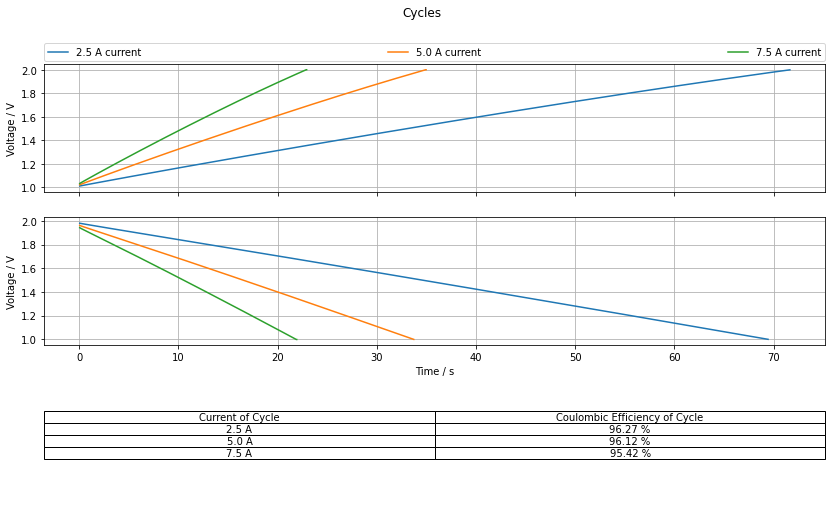

In [21]:
    figure, (chargeAxis, dischargeAxis, table) = plt.subplots(3, 1, figsize=[14,8])
    figure.suptitle("Cycles")
    
    for cycle in range(cycles):
        chargeAxis.plot(timeChargeCycleData[cycle], voltageChargeCycleData[cycle], label="{:.1f} A current".format(np.abs(currentsInCycles[cycle])))
        dischargeAxis.plot(timeDischargeCycleData[cycle], voltageDischargeCycleData[cycle], label="{:.1f} A current".format(np.abs(currentsInCycles[cycle])))
        
    chargeAxis.get_shared_x_axes().join(chargeAxis, dischargeAxis)
    
    chargeAxis.set_ylabel("Voltage / V")
    chargeAxis.grid(which="both")
    plt.setp(chargeAxis.get_xticklabels(), visible=False)
    
    dischargeAxis.set_xlabel("Time / s")
    dischargeAxis.set_ylabel("Voltage / V")
    dischargeAxis.grid(which="both")
    
    chargeAxis.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc="lower left", ncol=3, mode="expand", borderaxespad=0.0)
    
    table.axis("off")
    collabel = ["Current of Cycle", "Coulombic Efficiency of Cycle"]
    cellText = [["{:.1f} A".format(current) for current in currentsInCycles], ["{:.2f} %".format(coulombic) for coulombic in coulombicEfficiency]]
    cellText = np.transpose(cellText)
    table.table(cellText=cellText, colLabels=collabel, loc="center", rowLoc="center", cellLoc="center")
    
    plt.show()
    
    figure.savefig("ChargingCycles.svg")

# Deployment of the source code

**The following instruction is not needed by the user.**

It automatically extracts the pure python code from the jupyter notebook to provide it for the user.  
Thus the user does not need jupyter itself and does not have to copy the code manually.

The code is stored in a notebook-like file with the extension .py.

In [3]:
    if executionInNotebook() == True:
        notebookCodeToPython("CoulombicEfficiency.ipynb")